In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

layers = tf.contrib.layers
framework = tf.contrib.framework
tfgan = tf.contrib.gan
%matplotlib inline

/Users/harshitsrivastava/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [13]:
def input_fn(data, batch_size):
    data = tf.to_float(data)
    dataset = tf.data.Dataset.from_tensor_slices(data)
    images = dataset.batch(batch_size)
    return images
#images = input_fn(x_train, batch_size)

In [4]:
# # 0 - aeroplane
# # 1 - Car
# idx, _ = np.where(y_train == 0)
# plt.imshow(x_train[idx[100]])

7


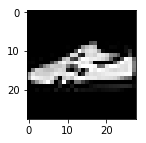

8


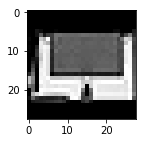

7


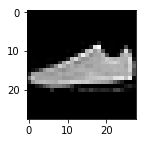

2


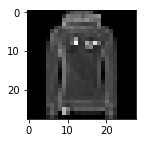

8


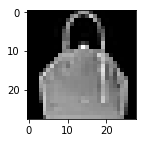

6


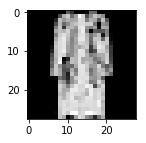

5


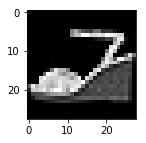

2


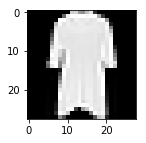

8


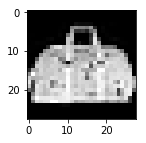

8


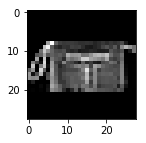

In [5]:
# Printing 10 randomly chosen images from the subset created
#images = x_train[idx]
x = np.random.randint(0, len(x_train), size=10)
for i in x:
    plt.figure(figsize=(4, 2))
    plt.imshow(x_train[i], cmap='gray')
    print (y_train[i])
    plt.show()

In [6]:
# Flatten the images ??
#images = 
noise_dims=100
real_images = input_fn(x_train, batch_size)
real_images = images.reshape(-1, x_train.shape[1], x_train.shape[2], 1)
#noisy_images = tf.random_normal([None, noise_dims])

# LeakyReLU activation
def leaky_relu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)
  
def show_images(sess):  
  # Testing
  # Generate images from noise, using the generator network.
    n = 6
    canvas = np.empty((28 * n, 28 * n))
    for i in range(n):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[n, 100])
        # Generate image from noise.
        g = sess.run(gen_image, feed_dict={noisy_input:z, is_training:False})
        # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
        g = (g + 1.) / 2.
        # Reverse colours for better display
        g = -1 * (g - 1)
        for j in range(n):
          # Draw the generated digits
          canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

    plt.figure(figsize=(n, n))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

In [7]:
def generator_fn(noise, weight_decay=2.5e-5, is_training=True):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    with framework.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)),\
    framework.arg_scope([layers.batch_norm], is_training=is_training,
                        zero_debias_moving_mean=True):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 256)
        net = tf.reshape(net, [-1, 7, 7, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

In [8]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5,
                     is_training=True):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        is_training: If `True`, batch norm uses batch statistics. If `False`, batch
            norm uses the exponential moving average collected from population 
            statistics.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        with framework.arg_scope([layers.batch_norm], is_training=is_training):
            net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

In [7]:
def generator(noise, is_training=True, reuse = False):
    with tf.variable_scope('generator', reuse = reuse):
        # Input shape = [None, 100]
        ### Fully-connected layer
        x = tf.layers.dense(noise, 7*7*128)
        # new shape = [None, 7*7*128]
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        ### 1st deconvolutional layer
        x = tf.reshape(x, shape = [-1, 7, 7, 128])
        x = tf.layers.conv2d_transpose(x, 64, kernel_size=5, strides=2, padding='SAME')
        # new shape = [None, 16, 16, 64]
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        ### 2nd deconvolutional layer
        x = tf.layers.conv2d_transpose(x, 1, kernel_size=5, strides=2, padding='SAME')
        # new shape = [None, 32, 32, 1]
        out = tf.nn.tanh(x)
        return out
#     with framework.arg_scope(
#         [layers.fully_connected, layers.conv2d_transpose],
#         activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
#         weights_regularizer=layers.l2_regularizer(weight_decay)),\
#                         framework.arg_scope([layers.batch_norm], is_training=is_training,
#                         zero_debias_moving_mean=True):
#         net = layers.fully_connected(noise, 1024)
#         net = layers.fully_connected(net, 8*8*128)
#         net = tf.reshape(net, [-1, 8, 8, 128])
#         net = layers.conv2d_transpose(net, 64, [5, 5], stride=2)
#         net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
#         # Make sure that generator output is in the same range as `inputs`
#         # ie [-1, 1].
#         net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

#         return net

In [8]:
def discriminator(img, reuse = False):
#     with tf.variable_scope('discriminator', reuse=False):
#         # Input shape = [None, 32, 32, 3]
#         ### 1st convolutional layer
#         dim = img.get_shape().as_list()
#         x = tf.reshape(img, shape = [-1, *dim[1:]])
#         x = tf.layers.conv2d(x, 64, kernel_size=5, strides=2, padding='same')
#         # new shape = [None, 16, 16, 64]
#         x = tf.layers.batch_normalization(x)
#         x = leaky_relu(x)
#         ### 2nd convolutional layer
#         x = tf.layers.conv2d(x, 128, kernel_size=5, strides=2, padding='same')
#         # new shape = [None, 8, 8, 128]
#         x = tf.layers.batch_normalization(x)
#         x = leaky_relu(x)
        
#         # Flatten
#         x = tf.reshape(x, shape=[-1, 7*7*128])
#         ### 1st Fully-connected layer
#         x = tf.layers.dense(x, 1024)
#         x = tf.layers.batch_normalization(x)
#         x = leaky_relu(x)
#         ### 2nd Fully-connected layer
#         out = tf.layers.dense(x, 1)
#         # new shape = [None, 1]
#         #out = tf.nn.sigmoid(out)
#         return out
    with framework.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        # Input shape = [None, 32, 32, 3]
        ### 1st convolutional layer
        net = layers.conv2d(img, 64, [5, 5], stride=2)
        # new shape = [None, 16, 16, 64]
        ### 2nd convolutional layer
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        # new shape = [None, 8, 8, 128]
        # Flatten
        net = layers.flatten(net)
        # new shape = [-1, 8*8*128]
        ### 1st Fully-connected layer
        net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        # new shape = [None, 1024]
        ### 2nd Fully-connected layer
        return layers.linear(net, 1)
        # new shape = [None, 1]


In [9]:
noise_dims = 100
batch_size = 128

gan_model = tfgan.gan_model(
    generator_fn=generator_fn,
    discriminator_fn=discriminator_fn,
    real_data=real_images,
    generator_inputs=tf.random_normal([batch_size, noise_dims])
)

ValueError: Trying to share variable Discriminator/Conv/weights, but specified dtype uint8 and found dtype float32_ref.

In [ ]:
x_train.shape

In [ ]:
wgan_loss = tfgan.gan_loss(gan_model, 
                           generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
                           discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
                           gradient_penalty_weight=1.0
                          )

In [ ]:
generator_opt = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_opt = tf.train.AdamOptimizer(0.001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(gan_model, wgan_loss, generator_opt, discriminator_opt)

In [ ]:
# Run the train ops in the alternating training scheme.
tfgan.gan_train(
    gan_train_ops,
    hooks=[tf.train.StopAtStepHook(num_steps=128)],
    logdir=FLAGS.train_log_dir)

In [ ]:
global_step = tf.train.get_or_create_global_step()
train_step_fn = tfgan.get_sequential_train_steps()
loss_values = []

#with tf.train.SingularMonitoredSession() as sess:
sess = tf.Session():
start_time = time.time()
for i in xrange(6001):
    cur_loss, _ = train_step_fn(
        sess, gan_train_ops, global_step, train_step_kwargs={})
    loss_values.append((i, cur_loss))
    if i % 500 == 0:
        print('Current loss: %f' % cur_loss)
        show_images(sess)